<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/practice_of_sub_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
%%capture --no-stderr
%pip install -U  langgraph


In [23]:
from typing_extensions import TypedDict
from typing import Literal, Optional, Annotated
from operator import add
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph


In [24]:
class log(TypedDict):
  id:str
  question:str
  docs:Optional[list]
  answer:str
  grade:int
  grader:str
  feedback:str

In [67]:
# sub graphs schemas input and output

class failurestate(TypedDict):
  clean_log:list[log]
  failures:list[log]
  fa_summery:str
  proceed_log:list[str]

class failureoutputstate(TypedDict):
  fa_summery:str
  proceed_log:list[str]

def get_failure(state):
  '''get log contain in failure'''
  clean_log = state['clean_log']
  failures = [log for log in clean_log if 'grade' in log]
  return{"failures":failures}

def generate_summery(state):
  '''get generate summery of failures'''
  failures= state['failures']
  fa_summery=('poor quality contain and question')
  return{'fa_summery':fa_summery, 'proceed_log': [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}



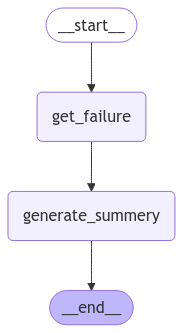

In [68]:
fa_builder = StateGraph(failurestate, input=failurestate, output=failureoutputstate)  # Use failurestate for fa_builder
fa_builder.add_node(get_failure, "get_failure")
fa_builder.add_node(generate_summery, "generate_summery")
fa_builder.add_edge(START, "get_failure")
fa_builder.add_edge("get_failure", "generate_summery")
fa_builder.add_edge("generate_summery", END)

graph=fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [74]:
class Questionsummerizationstate(TypedDict):
  clean_log:list
  qa_summery:str  # qa_summery is defined here
  report:str
  proceed_log:list[str]

class Questionsummerizationoutputstate(TypedDict):
  report:str
  proceed_log:list[str]

def generate_summary(state):
  '''get summery report'''
  clean_log = state["clean_log"]
  qa_summery = "Questions focused on usage of ChatOllama and Chroma vector store."
  # Return 'qa_summery' instead of 'qs_summery'
  return {"qa_summery":  qa_summery, "processed_logs": [f"summery-on-log-{log['id']}" for log in clean_log]}


def sent_to_lack(state):
  qa_summery = state ["qa_summery"]  # Now it can access qa_summery
  report = "this report is generated by AI "
  # Return a dictionary with 'report' as the key, not a set
  return {"report": report}

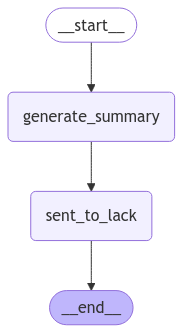

In [75]:
qa_builder = StateGraph(Questionsummerizationstate, input=Questionsummerizationstate, output=Questionsummerizationoutputstate)  # Use Questionsummerizationstate for qa_builder
qa_builder.add_node(generate_summary, "generate_summary")
qa_builder.add_node(sent_to_lack, "sent_to_lack")
qa_builder.add_edge(START, "generate_summary")
qa_builder.add_edge("generate_summary", "sent_to_lack")
qa_builder.add_edge("sent_to_lack", END)
graph=qa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [76]:
class EntryGraph(TypedDict):
    raw_logs: list[log]  # Changed to raw_logs
    clean_log: list[log]
    fa_summery: str
    report: str
    proceed_log: list[str]


def clean_logs(state):
    raw_logs = state["raw_logs"]  # Access the 'raw_logs' key from the input state
    clean_log = raw_logs
    return {"clean_log": clean_log}  # Return a dictionary with 'clean_log' as the key


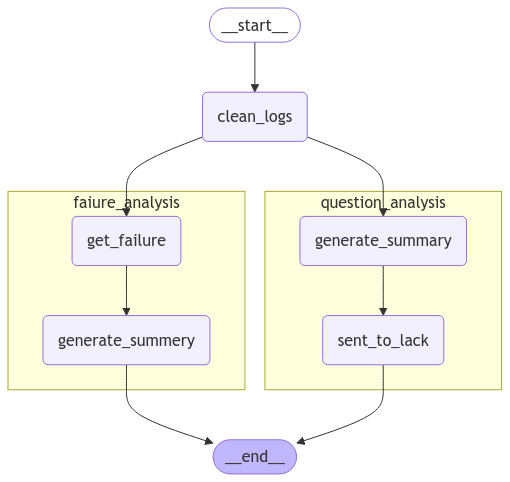

In [77]:
entry_builder = StateGraph(EntryGraph)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("faiure_analysis", fa_builder.compile())
entry_builder.add_node("question_analysis", qa_builder.compile())
entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "faiure_analysis")
entry_builder.add_edge("clean_logs", "question_analysis")
entry_builder.add_edge("faiure_analysis", END)
entry_builder.add_edge("question_analysis", END)
graph: CompiledStateGraph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))



In [80]:
question_answer = log(
    id="1",
    question="what is Generative AI?",
    answer="yes this is power of algrothium.'",
)

question_answer_feedback = log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer, question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'what is Generative AI?',
   'answer': "yes this is power of algrothium.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'clean_log': [{'id': '1',
   'question': 'what is Generative AI?',
   'answer': "yes this is power of algrothium.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'fa_summery': 'poor quality contain and question',
 'report': 'this report is genera

In [79]:
raw_logs

[{'id': '1',
  'question': 'How can I import ChatOllama?',
  'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
 {'id': '2',
  'question': 'How can I use Chroma vector store?',
  'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
  'grade': 0,
  'grader': 'Document Relevance Recall',
  'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}]